# Use ONNX Single Shot MultiBox Detector (SSD)

 In this notebook, we investigate how to use the [SSD](https://arxiv.org/abs/1512.02325) computer vision model serialized in [ONNX](https://onnx.ai/) format. For performing this experiment, we are using the "animal" dataset, which contains images of cute dogs and cats.

## Setup Environment

But before we start, let's set up our working environment. It will help us to keep the project directory clean. All artifacts generated within the project will be placed to the "tmp" directory and will be ignored by Git.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import numpy as np
from PIL import Image
from utils import load_dataset, load_image, show_image

# Let's make a temporary directory for all artifacts created by this notebook.
import os
if not os.path.exists('tmp'):
    os.makedirs('tmp')

## Prepare Dataset

For creating the ML model we are loading the "animal" dataset which includes the following images:

| Photo           | Description                  |
| ----------------| ---------------------------- |
| cat-1.jpeg      | an image of a cat            |
| cat-2.jpeg      | an image of a cat            |
| cat-3.jpeg      | an image of a cat            |
| cat-m.jpeg      | an image of 5 cats           |
| dog-1.jpeg      | an image of a dog            |
| dog-2.jpeg      | an image of a dog            |
| dog-3.jpeg      | an image of a dog            |
| dog-m.jpeg      | an image of 3 dogs           |
| dog-n-cat.jpeg  | an image of 2 cats and 1 dog |

Please note, this data set is used for inference experiments only.

In [2]:
# Sets the loading dataset name.
dataset_name = 'animal'

# Loads the dataset.
dataset = load_dataset(dataset_name)

## Download SSD ONNX Model

Use the following [page](https://github.com/onnx/models/tree/master/vision/object_detection_segmentation/ssd) to get the URL for the SSD ONNX model.

**Please note that downloading ONNX models have a large size. To prevent the repeated download of the same model on the notebook restart we check whether the model already exists. If a model exists we skip the download. To force download, go to the "tmp" directory and delete the "ssd.onnx" file.**

In [3]:
# Sets the model name.
model_name = 'ssd'

# Download the ONNX model.
if not os.path.exists(os.path.join('tmp', f'{model_name}.onnx')):
    !wget -O tmp/ssd.onnx https://github.com/onnx/models/raw/master/vision/object_detection_segmentation/ssd/model/ssd-10.onnx
else:
    print('This notebook is using an already downloaded model.')
                      

This notebook is using an already downloaded model.


## Define Image Pre/Past-processors

### Pre-process Image

In [4]:
def preprocess(image):
    image = image.resize((1200, 1200), Image.BILINEAR)
    image_data = np.array(image)
    image_data = np.transpose(image_data, [2, 0, 1])
    image_data = np.expand_dims(image_data, 0)
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    norm_image_data = np.zeros(image_data.shape).astype('float32')
    for i in range(image_data.shape[1]):
        norm_image_data[:,i,:,:] = (image_data[:,i,:,:]/255 - mean_vec[i]) / stddev_vec[i]
    return norm_image_data

### Post-process Image

In [5]:
def postprocess(image, classes, boxes, labels, scores, score_threshold):
    # Resize boxes
    image = np.array(image)

    report = ""
    for box, label, score in zip(boxes, labels, scores):

        # Showing boxes with score > 0.7
        if score <= score_threshold:
            continue
        
        image = cv2.rectangle(
            image, 
            (int(box[0] * image.shape[1]), int(box[1] * image.shape[0])),
            (int(box[2] * image.shape[1]), int(box[3] * image.shape[0])),
            (100,0,100),
            2)
        image = cv2.putText(
            image,
            classes[label] + ':' + str(np.round(score, 2)),
            (int(box[0] * image.shape[1]), int(box[1] * image.shape[0] +10)),
            cv2.FONT_HERSHEY_TRIPLEX,
            0.5,
            (255,255,255)
        )
        report += "%s: %s: %.2f\n" % (str(box), classes[label], score)

    return image, report

## Segment Images

First we need to load the model.

In [7]:
import onnxruntime as rt
sess = rt.InferenceSession(os.path.join('tmp', f'{model_name}.onnx'))
classes = [line.rstrip('\n') for line in open(os.path.join('config', 'coco_classes.txt'))]

Load image for segmentation.

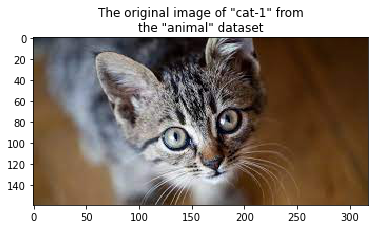

In [8]:
image_name = 'cat-1'
image = load_image(dataset_name, image_name)
show_image(image, model_name, 'orig', image_name, dataset_name)

Preprocess image for the model input.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


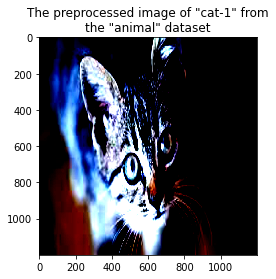

In [9]:
pre_image = preprocess(image)
show_image(pre_image[0].transpose(1,2,0), model_name, 'pre', image_name, dataset_name)

Use ONNX model for segmentation.

In [10]:
boxes, labels, scores = sess.run(
    None, {sess.get_inputs()[0].name: pre_image}
)

Visualize the model predictions.

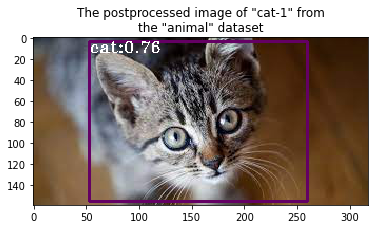

Selected Objects (score threshold 0.70):
[0.16762152 0.02953199 0.81907797 0.97739697]: cat: 0.76



In [11]:
score_threshold = 0.7
post_image, report = postprocess(
    image, classes, boxes[0], labels[0], scores[0], score_threshold)
show_image(post_image, model_name, 'post', image_name, dataset_name)
print('Selected Objects (score threshold %.2f):\n%s' % (score_threshold, report))